In [1]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import Dataset
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from utils_train import *
import deepdish as dd
from configs import DatasetConfiguration
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed=seed)

splitting = 'random'
data_setting = 'raw'
model_setting = 'dl4tsc_inc'

assert splitting in ['random','randomcv','custom'], "Wrong splitting method given."
assert data_setting in ['raw','stft','psd_dB', 'cwt'], "Wrong data settting given."
assert model_setting in ['wavenet','lstm','gru','conv1d','conv1d_psd',
                        'DenseNet121','DenseNet169','DenseNet201',
                        'InceptionResNetV2','VGG16','VGG19',
                        'dl4tsc_fcn','dl4tsc_res', 'tsc_res_baseline',
                        'tsc_fcn_baseline', 'conv1d_baseline', 'dl4tsc_inc'], "Wrong model setting given"

In [2]:
dconf = DatasetConfiguration(names=['Wingbeats','LG','Leafminers'])
dconf.select(name='Wingbeats',species=['Ae. aegypti','Ae. albopictus', 'C. quinquefasciatus', 'C. pipiens'])
dconf.select(name='LG', species=['LG_zapr_26_09'])
dconf.select(name='Leafminers', species=['P_Cichorii'])
dconf.read()

In [3]:
print(dconf.target_classes)
print(dconf.labels.value_counts())

['Ae. aegypti', 'Ae. albopictus', 'C. quinquefasciatus', 'C. pipiens', 'LG_zapr_26_09', 'P_Cichorii']
Ae. aegypti            85553
C. quinquefasciatus    74599
C. pipiens             30415
Ae. albopictus         20231
LG_zapr_26_09           7210
P_Cichorii              1600
dtype: int64


In [4]:
X = dconf.fnames.tolist()
le = LabelEncoder()
y = le.fit_transform(dconf.labels.tolist())

In [5]:
def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

names = list(get_integer_mapping(le).keys())

In [6]:
X,y = shuffle(X, y, random_state=seed)
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(X,y,test_size=0.1, val_size=0.2, random_state=seed)

In [7]:
using_conv2d = False
traincf = TrainConfiguration(dataset=dconf, setting=data_setting, model_name=f'paper2_{splitting}_{data_setting}_{model_setting}_weights')
modelconf = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, target_names=traincf.target_names).config

############ INPUT SHAPE:(5000, 1)
/home/kalfasyan/projects/wingbeat_frequencies/temp_data/


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

new_model = Model(modelconf.inputs, modelconf.layers[-2].output)
x = Dense(traincf.targets, activation='relu')(new_model.layers[-1].output)
x = Dense(traincf.targets, activation='softmax')(x)

del modelconf
model = Model(inputs=new_model.inputs, outputs=x)

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
train_stats = calculate_train_statistics(X_train=X_train, setting=data_setting)

In [11]:
# Actual training
h = model.fit_generator(train_generator(X_train, y_train, 
                                    batch_size=traincf.batch_size,
                                    target_names=traincf.target_names,
                                    setting=traincf.setting,
                                    preprocessing_train_stats=train_stats,
                                    using_conv2d=using_conv2d),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                    epochs = traincf.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf.batch_size,
                                                        target_names=traincf.target_names,
                                                        setting=traincf.setting,
                                                        preprocessing_train_stats=train_stats,
                                                        using_conv2d=using_conv2d),
                    validation_steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))),
                    callbacks=traincf.callbacks_list,
                    use_multiprocessing=False,
                    workers=1,
                    max_queue_size=32)

Epoch 1/100
4941/4942 [============================>.] - ETA: 0s - loss: 0.2916 - accuracy: 0.8962
Epoch 00001: val_loss improved from inf to 0.27689, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/paper2_random_raw_dl4tsc_inc_weights.h5
4942/4942 [==============================] - 1505s 305ms/step - loss: 0.2916 - accuracy: 0.8962 - val_loss: 0.2769 - val_accuracy: 0.8956
Epoch 2/100
4941/4942 [============================>.] - ETA: 0s - loss: 0.1823 - accuracy: 0.9352
Epoch 00002: val_loss improved from 0.27689 to 0.22482, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/paper2_random_raw_dl4tsc_inc_weights.h5
4942/4942 [==============================] - 1497s 303ms/step - loss: 0.1823 - accuracy: 0.9352 - val_loss: 0.2248 - val_accuracy: 0.9162
Epoch 3/100
4941/4942 [============================>.] - ETA: 0s - loss: 0.1551 - accuracy: 0.9449
Epoch 00003: val_loss improved from 0.22482 to 0.18700, saving model to /home/kalfasyan/project

In [12]:
results = {}
results['train_loss'] = h.history['loss']
results['train_score'] = h.history['accuracy']
results['val_loss'] = h.history['val_loss']
results['val_score'] = h.history['val_accuracy']
results['lr'] = h.history['lr']

In [13]:
# model.save(f'../temp_data/paper2_{splitting}_{data_setting}_{model_setting}_weights.h5')

In [14]:
model.load_weights(traincf.top_weights_path)

y_pred = model.predict_generator(valid_generator(X_test, 
                                                y_test, 
                                                batch_size=traincf.batch_size, 
                                                setting=traincf.setting, 
                                                target_names=traincf.target_names,
                                                preprocessing_train_stats=train_stats,
                                                using_conv2d=using_conv2d),
        steps = int(math.ceil(float(len(X_test)) / float(traincf.batch_size))))

In [15]:
# CALCULATING METRICS
results['bacc'] = balanced_accuracy_score(np.array(y_test), np.argmax(y_pred, axis=1))
results['test_loss'] = log_loss(y_test, y_pred)

In [21]:
val_loss = results['val_loss']
idx = pd.Series(val_loss).idxmin()
print(results['train_score'][idx])
print(results['val_score'][idx])
print(results['bacc'])
results['train_score_best'] = results['train_score'][idx]
results['val_score_best'] = results['val_score'][idx]

0.97844636
0.973272
0.9688450110697837


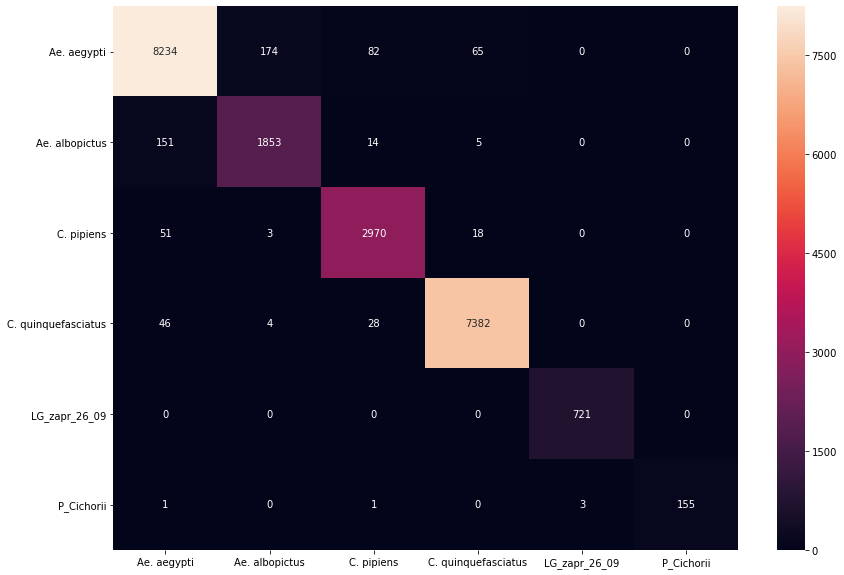

In [22]:
plt.figure(figsize=(14,10))
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
results['cm'] = cm
sb.heatmap(cm, annot=True, fmt='g', xticklabels=names, yticklabels=names)

In [23]:
dd.io.save(f'../temp_data/paper2_{splitting}_{data_setting}_{model_setting}_results.h5', {'results':results})

In [25]:
loaded = dd.io.load(f'../temp_data/paper2_{splitting}_{data_setting}_{model_setting}_results.h5')['results']

In [61]:
df = pd.concat([pd.DataFrame(y_pred, columns=names), pd.Series(y_test, name='true')],axis=1)
df['pred'] = pd.DataFrame(y_pred, columns=[0,1,2,3,4,5]).idxmax(axis=1)
df[(df.true != df.pred) & (df.true==5)]

,Ae. aegypti,Ae. albopictus,C. pipiens,C. quinquefasciatus,LG_zapr_26_09,P_Cichorii,true,pred
14442,1.114512e-06,6.093138e-08,6.342278e-07,9.999982e-01,1.185315e-10,9.279045e-11,3,3
684,9.269226e-01,2.153806e-05,6.709854e-04,7.238462e-02,1.715035e-07,8.387077e-08,0,0
20700,1.276878e-07,1.455766e-08,1.204571e-06,9.999987e-01,4.160124e-12,5.903260e-13,3,3
5762,9.999368e-01,1.625076e-05,2.106419e-07,4.675199e-05,1.491454e-08,6.647306e-09,0,0
20925,8.261108e-01,1.584686e-01,1.626943e-04,1.388885e-02,5.690748e-07,1.368491e-03,0,0
11017,9.964775e-01,3.511332e-03,2.585894e-06,8.480039e-06,5.481864e-10,7.995676e-08,0,0
18498,2.031358e-03,6.877955e-06,2.464902e-01,7.514716e-01,3.633059e-10,9.354473e-10,3,3
2096,2.256095e-04,1.805585e-06,1.763242e-05,9.997548e-01,6.722204e-10,1.007712e-07,3,3
3690,3.917453e-06,4.448560e-07,2.458330e-06,9.999931e-01,1.659533e-10,8.991236e-10,3,3
9857,1.209833e-08,8.948978e-08,9.999999e-01,7.886385e-11,1.483858e-08,5.192738e-10,2,2
